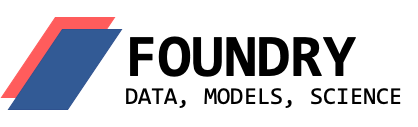

# Foundry Model Publication Tutorial for Beginners

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MLMI2-CSSI/foundry/blob/main/examples/publishing-guides/model_publishing.ipynb)

This introduction uses Foundry to:

1.   Describe a Scikit-Learn model using the correct metadata
2.   Publish the model to Foundry


This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run

In [ ]:
try:
    import google.colab
    no_local_server = True
    no_browser = True
    globus = False
except:
    no_local_server = False
    no_browser = False
    globus = True

# Installing Foundry
First we'll need to install Foundry and [MDF](https://materialsdatafacility.org/). If you already have Foundry installed in your local environment and you are running the code locally, you do not need to run this block. If you're using Google Colab or do not have Foundry installed locally, you will need to run the code below to install.

In [ ]:
!pip install foundry_ml

# Importing and Instantiating Foundry
Now we can import Foundry!

In [ ]:
from foundry import Foundry

We'll also need to instantiate it. To do so, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code (this should happen twice).

In [ ]:
f = Foundry(no_local_server=no_local_server, no_browser=no_browser)

Before publishing, you need join the correct Globus groups so that you have the permissions to publish to Foundry! [Join this group](https://app.globus.org/groups/cc192dca-3751-11e8-90c1-0a7c735d220a/about) and [this group](https://app.globus.org/groups/42a7a77c-4789-11ea-95b7-0ef992ed7ca1/about) to get started. Follow the 
prompts to get set up.

# Loading Data and Training our Model
Here we'll be training an SVM classifier from Scikit-Learn on the iris dataset. 

First, let's load the iris data from Foundry!

In [ ]:
f = f.load("_test_foundry_iris_dev_v2.1", globus=globus)

In [ ]:
res = f.load_data()
X,y = res['train']

Now that we've loaded the data, let's take a peek!

In [ ]:
X.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

And the classes of interest:

In [ ]:
# 0 - 2 represent the different iris species, setosa, versicolor, and virginica
y.head()

y
0  0
1  0
2  0
3  0
4  0

In [ ]:
import numpy as np

# need to flatten to shape (n_cols, ) for sklearn
y_flat = y['y'].ravel()
y_flat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Now that the data are loaded, we can train our model.

In [ ]:
print('Loaded {} rows with {} columns:'.format(len(X), len(X.columns)),
      X.columns)
from sklearn.svm import SVC

# Fit the model
model = SVC(kernel='linear', C=1, probability=True)
model.fit(X, y_flat)
print('Trained a SVC model')

model

Loaded 100 rows with 4 columns: Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')
Trained a SVC model


SVC(C=1, kernel='linear', probability=True)

In [ ]:
import pickle as pkl

# Save the model using pickle
with open('model.pkl', 'wb') as fp:
    pkl.dump(model, fp)
print('Saved model to disk')

Saved model to disk


# Describing our Model

In Foundry, you can publish models or functions. We need to create the appropriate metadata to tell Foundry what our model or function is all about!

Here we're going to use a Scikit-Learn model. 

A few key terms are required for the metadata, here is the general format for a Scikit-Learn model: 

```
title = <the full title of the model to be published>
short_name = <the shorthand name for the model, i.e. what someone
        uses to download your model>
creators = [<list of author names>]
servable_type = <one of these options: "static_method", "class_method", "keras", "pytorch", "tensorflow", "sklearn">
servable_options = {
        "filepath": <full path to saved model>,
        "classes": <names of classes of interest>,
        "n_input_columns": <number of training features>
    }
```

Other model or function types include Keras, Tensorflow 1 & 2, PyTorch, and Python functions. These have slightly different options -- you can currently read more about them in the [Data and Learning Hub documentation](https://dlhub-sdk.readthedocs.io/en/latest/servable-types.html) (which Foundry builds upon). 

Now that we have an idea of what the metadata look like, let's create the metadata for our iris model.

In [ ]:
# the names of the iris species in question
class_names = ['setosa', 'versicolor', 'virginica']
# the number of input columns, i.e. features
n_columns = len(X.columns)

# set model options
title = "Iris SVM (test publication)"
short_name = "everybody_iris_test_svm"
creators = ["Everybody, M"]
servable_type = "sklearn"
servable_options = {
        "filepath": "model.pkl",
        "classes": class_names,
        "n_input_columns": n_columns
    }

# Publishing and Running Our Model

Now that we have our metadata, we can publish our model on Foundry.

In [ ]:
# publish our model to Foundry! that's it!
f.publish_model(title, creators, short_name, servable_type, serv_options)

DLHub schema successfully validated


'f024517e-d436-4ff9-9599-607291f006f7'

Congrats, you've published a model to Foundry! To run the model in the cloud, simply specify the model by its user and name

In [ ]:
# create toy test data to run the model on
test_data = [[6.7,3.1,4.4,1.4], [4.8,3.0,1.4,0.1], [7.2,3.6,6.1,2.5]]
pred = f.run("aristana_uchicago/everybody_iris_test_svm", test_data)

# view the predictions
pred

array([[0.00612405, 0.9855858 , 0.00829015],
       [0.96486799, 0.02522498, 0.00990703],
       [0.00281698, 0.00133494, 0.99584808]])